# Titanic Survivor Prediction

Download the [Titanic Dataset](https://www.kaggle.com/datasets/heptapod/titanic) from Kaggle.

In [1]:
import csv 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from copy import deepcopy
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from typing import Callable, List, Tuple, Any, Dict
from sklearn.model_selection import GridSearchCV
import matplotlib.cm as cm

## Data Preprocessing

In [2]:
train_data = pd.read_csv('../EP_Datasets/titanic/train.csv')
test_data = pd.read_csv('../EP_Datasets/titanic/test.csv')

### Data Exploration and Cleaning

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Add a new column to the dataset to check for duplicates
train_data["duplicate"]= train_data.duplicated()

print(f"Duplicated Entries: {len(train_data[train_data['duplicate']==True])}")

Duplicated Entries: 0


In [5]:
# drop the duplicates column
train_data = train_data.drop(['duplicate'], axis=1)

The dataset description provided the following summaries of these features.

- **PassengerId:** the id of the passenger. 
- **Survived:** the dependent variable specifying whether a passenger survived.
- **Pclass:** the passenger's ticket class
- **Name**: the passenger's name
- **Sex**: the passenger's gender
- **Age**: the passenger's age
- **Sibsp:** the number of siblings and spouses the passenger had aboard the ship
- **Parch**: the number of parents and children the passenger had aboard the ship
- **Ticket**: the passenger's ticket number
- **Fare**: the price of the ticket
- **Cabin**: The passenger's cabin number
- **Embarked**: The port of embarkation (C = Cherbourg, Q = Queenstown, S= Southampton)

Some features can be removed before applying any feature analysis techniques. The `PassengerId`, `Ticket`, and `Name` features will not provide value to model predictions and the model could use these features as identifiers when predicting who survived. Therefore, leaving any of these variables in the dataset could provide false evaluation results. The cells below remove these features from the dataset and split the class labels. Feature exploration techniques will help determine the significance of the remaining features.

In [6]:
train_labels = train_data["Survived"]
train_df = train_data.drop(["PassengerId", "Survived", "Name", "Ticket"], axis = 1)

# save passenger ids of the test set for kaggle submissions
test_pass_ids = test_data["PassengerId"]
test_df = test_data.drop(["PassengerId", "Name", "Ticket"], axis = 1)
print("Train Data:\n")
train_df.head()

Train Data:



,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,NaN,S


In [7]:
print("Test Data:\n")
test_df.head()

Test Data:



,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S


In [8]:
print(f"The training data contains {len(train_df)} examples, and the test data contains {len(test_df)} examples.")

The training data contains 891 examples, and the test data contains 418 examples.


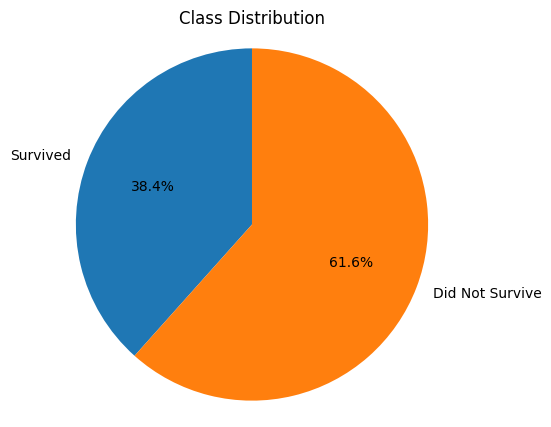

In [9]:
# plot the class distribution
fig = plt.figure(figsize=(5, 5))
labels = 'Survived', 'Did Not Survive'
survivor_dist = [list(train_labels).count(1), list(train_labels).count(0)] 

plt.pie(survivor_dist, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.title('Class Distribution')
plt.show()

K-fold validation will be a good evaluation technique for this dataset due to the limited training examples. Stratified k-fold validation will be used for this problem because there is an uneven distribution of survivors vs. non-survivors. The F1 score will be a good evaluation metric for the imbalanced classes in this problem. The stratified k-fold function will also display the accuracy in case Kaggle uses this metric for the final evaluation instead of the F1 score. However, this notebook focuses on the F1 score. 

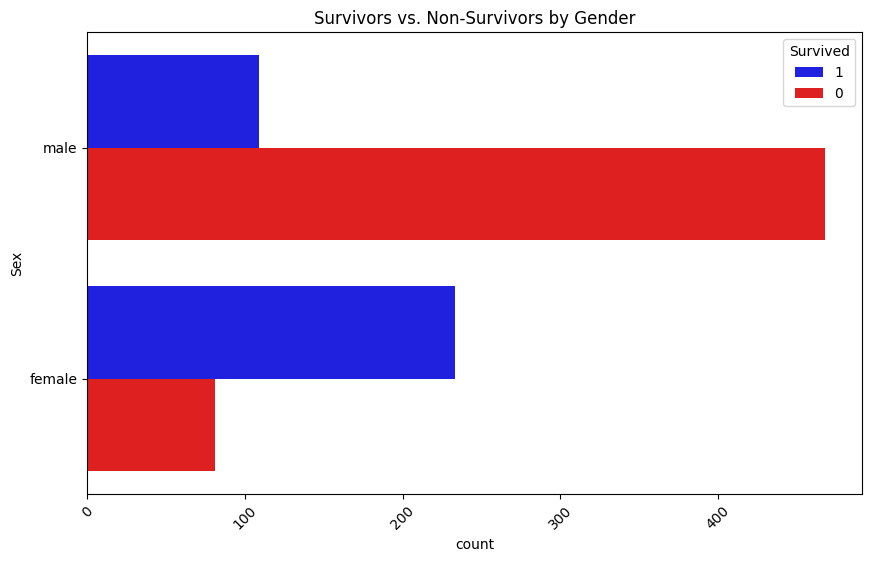

In [10]:
# Plot survivors vs. non-survivors by gender
plt.figure(figsize=(10,6))
colors = ["blue", "red"] 
sns.countplot(y='Sex', hue='Survived', data=train_data, hue_order=[1, 0], palette=colors)
plt.xticks(rotation=45)
plt.title('Survivors vs. Non-Survivors by Gender')
plt.show()

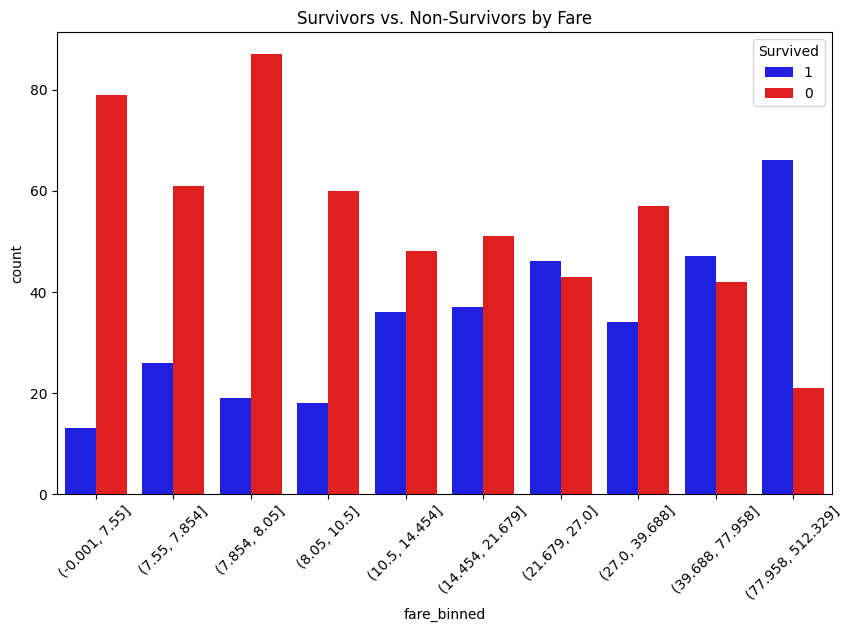

In [11]:
# create fare bins
train_data['fare_binned'] = pd.qcut(train_data['Fare'], q=10)

# plot survivors vs. non-survivors by Fare
plt.figure(figsize=(10,6))
sns.countplot(x='fare_binned', hue='Survived', data=train_data, hue_order=[1, 0], palette=colors)
plt.xticks(rotation=45)
plt.title('Survivors vs. Non-Survivors by Fare')
plt.show()

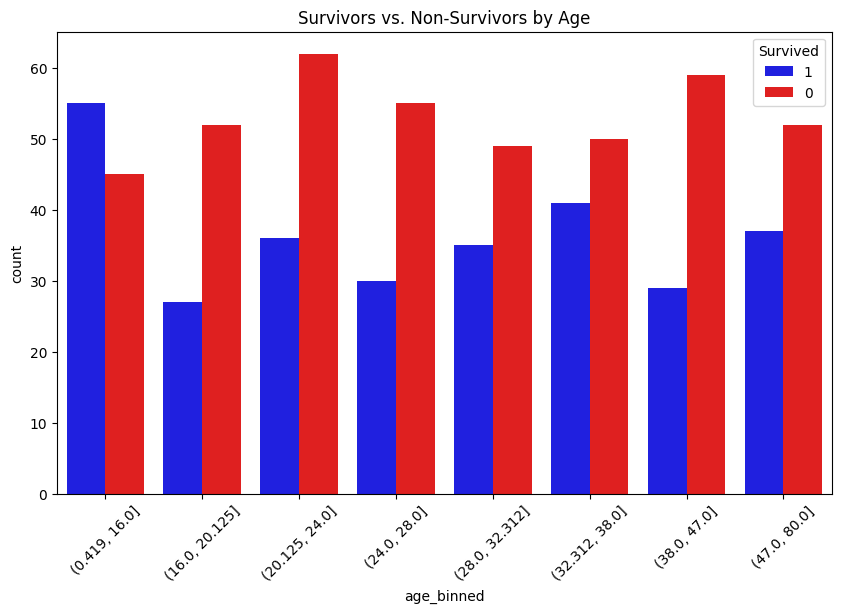

In [12]:
# create age bins
train_data['age_binned'] = pd.qcut(train_data['Age'], q=8)
# plot survivors vs. non-survivors by age
plt.figure(figsize=(10,6))
sns.countplot(x='age_binned', hue='Survived', data=train_data, hue_order=[1, 0], palette=colors)
plt.xticks(rotation=45)
plt.title('Survivors vs. Non-Survivors by Age')
plt.show()

The visual analysis showed that the `Sex` and `Fare` features significantly impact the dependent variable. `Age` was less valuable for visualization purposes. However, a machine learning model could still find trends in this feature. For example, the majority of passengers between the ages of `24 to 28` and `38 to 47` did not survive.

### Impute missing values

In [13]:
# check for null values
print(f"Missing values in the training set:\n{train_df.isnull().sum()}")

Missing values in the training set:
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


The `Cabin` feature should be removed from the dataset because it contains mostly null entries. The missing `Age` values will be imputed since this could be a valuable feature. 

In [14]:
# drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [15]:
# Check for missing values in the test set
print(f"Missing values in the test set:\n{test_df.isnull().sum()}")

Missing values in the test set:
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64


Since the `Age` column is null for roughly 25% of the training and test sets, a model-based imputation technique using k-nearest neighbors could be valuable. The two missing values for the `Embarked` variable can be imputed with the mode. The missing `Fare` value in the test set can be imputed with the average fare from the training set. 

In [16]:
# impute missing embarked and fare values
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
test_df['Fare'].fillna(train_df['Fare'].mean(), inplace=True)

# one hot encode the gender and embarked variables 
train_imputed_df = pd.get_dummies(train_df, columns=['Sex'], drop_first=True)
test_imputed_df = pd.get_dummies(test_df, columns=['Sex'], drop_first=True)
train_imputed_df = pd.get_dummies(train_imputed_df, columns=['Embarked'])
test_imputed_df = pd.get_dummies(test_imputed_df, columns=['Embarked'])

# use KNN to impute missing Age values
imputer = KNNImputer(n_neighbors=3)
train_imputed = imputer.fit_transform(train_imputed_df)
test_imputed = imputer.transform(test_imputed_df)

# turn back into a dataframe with the imputed values
train_df = pd.DataFrame(train_imputed, columns=train_imputed_df.columns)
test_df = pd.DataFrame(test_imputed, columns=test_imputed_df.columns)

In [17]:
print(f"Missing values in the training set:\n{train_df.isnull().sum()}")

Missing values in the training set:
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [18]:
print(f"Missing values in the test set:\n{test_df.isnull().sum()}")

Missing values in the test set:
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [19]:
# ensure all data types are the same
print(train_df.dtypes)

Pclass        float64
Age           float64
SibSp         float64
Parch         float64
Fare          float64
Sex_male      float64
Embarked_C    float64
Embarked_Q    float64
Embarked_S    float64
dtype: object


In [20]:
train_df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


### Feature Exploration

The following section uses a random forest model to explore feature significance. 

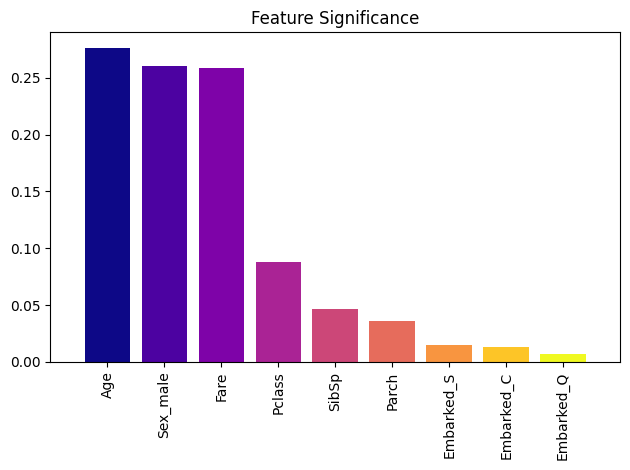

In [21]:
# random forest feature significance
features = train_df.columns

# the following code is from Python Machine Learning, 3rd Edition, pg. 141
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(train_df, train_labels)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

colors = cm.plasma(np.linspace(0, 1, len(features)))
plt.title('Feature Significance')
plt.bar(range(train_df.shape[1]), importances[indices], align='center', color=colors)
plt.xticks(range(train_df.shape[1]), features[indices], rotation=90)
plt.xlim([-1, train_df.shape[1]])
plt.tight_layout()

The results showed that the `Embarked` feature had a low impact on passenger survival. The `SibSp` and `Parch` features had a much lower significance score than the `Fare`, `Age`, and `Sex_male` features. The sections below will test the models with and without the `SinSp` and `Parch` features. The `Embarked` feature will be removed.

In [22]:
# remove the embarked feature
train_df = train_df.drop(['Embarked_C', 'Embarked_S', 'Embarked_Q'], axis=1)
test_df = test_df.drop(['Embarked_C', 'Embarked_S', 'Embarked_Q'], axis=1)

In [23]:
train_df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male
0,3.0,22.0,1.0,0.0,7.2500,1.0
1,1.0,38.0,1.0,0.0,71.2833,0.0
2,3.0,26.0,0.0,0.0,7.9250,0.0
3,1.0,35.0,1.0,0.0,53.1000,0.0
4,3.0,35.0,0.0,0.0,8.0500,1.0


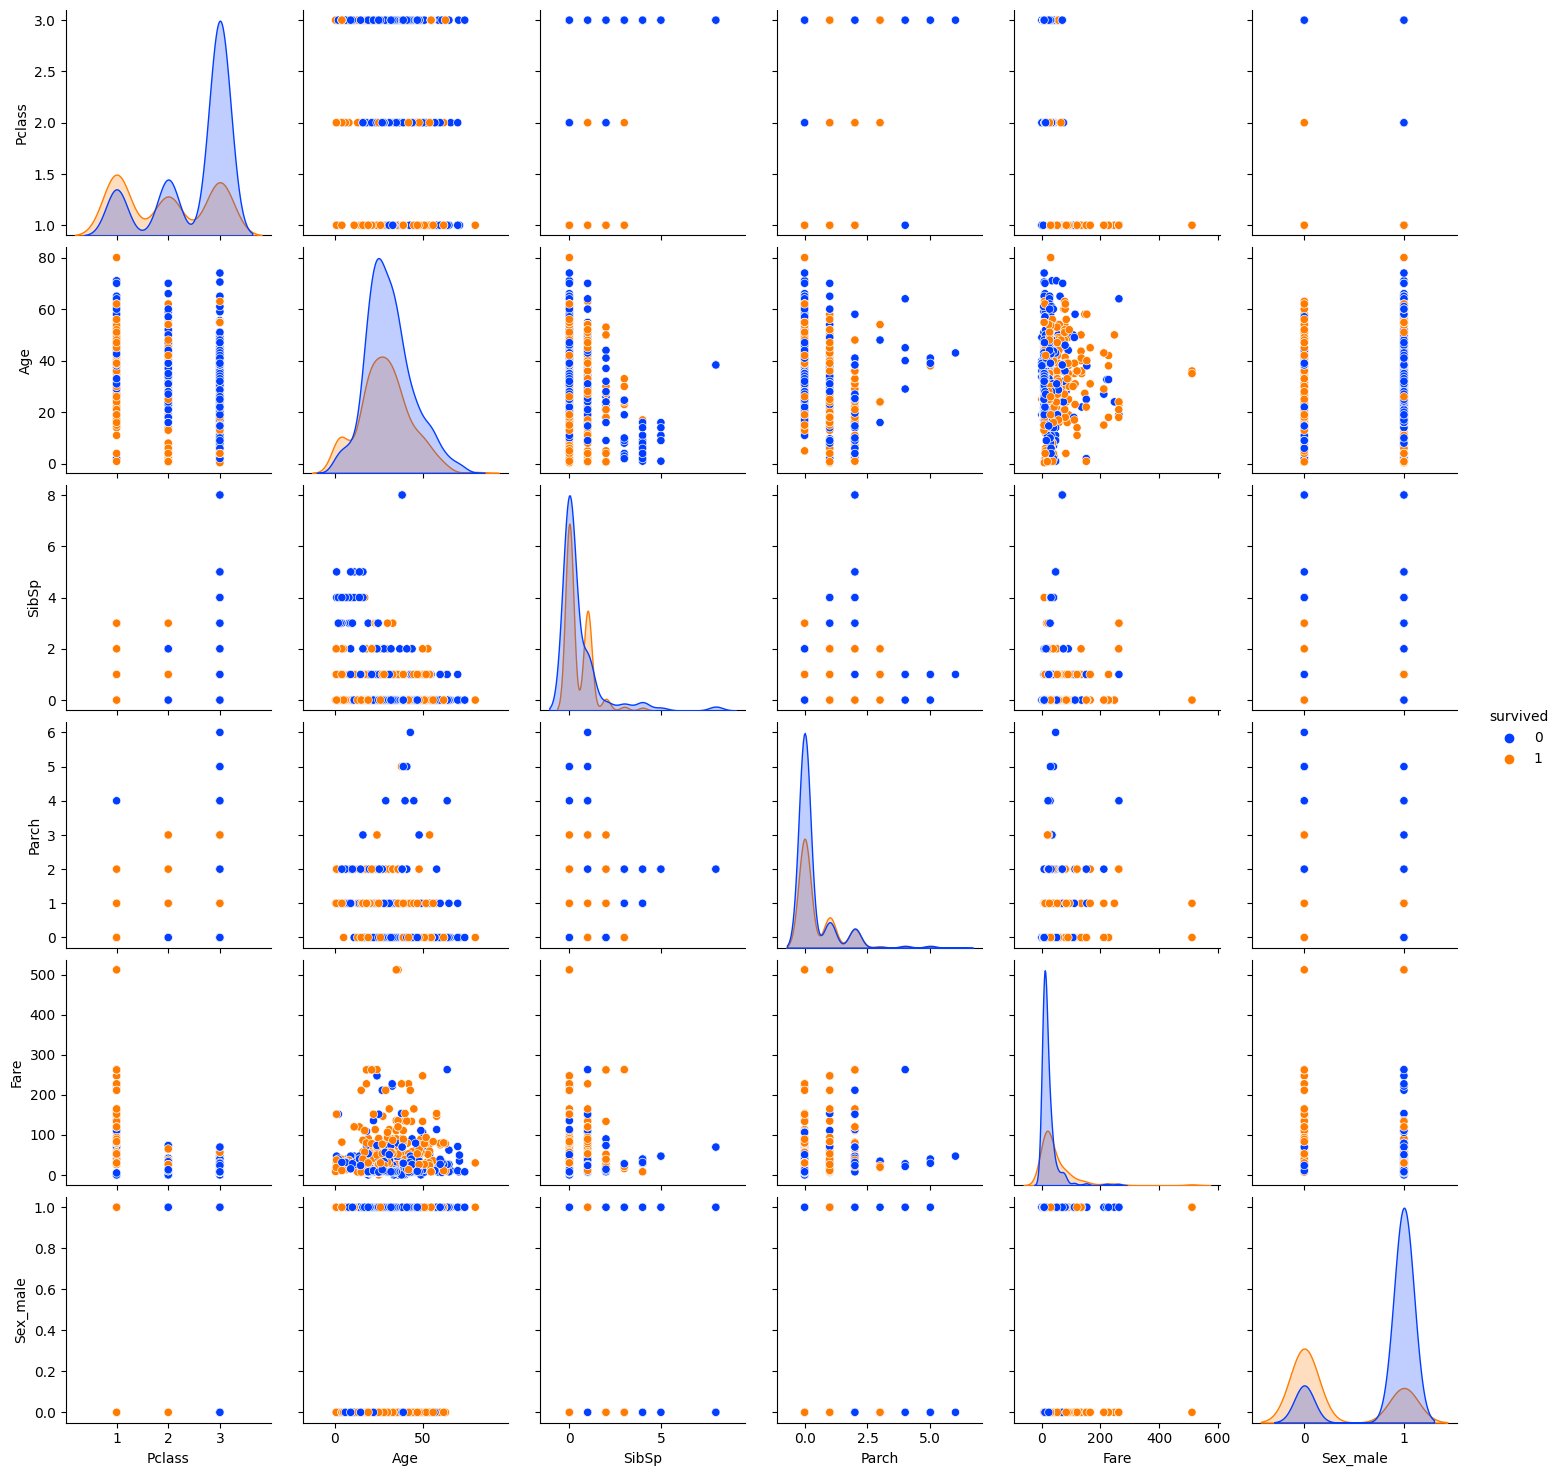

In [24]:
# display a pairplot for the remaining features
corr_df = deepcopy(train_df)
corr_df['survived'] = train_labels
sns.pairplot(corr_df, hue='survived', palette='bright')
plt.show()

The `Fare` feature has a couple of outliers with much higher values than the other examples. The cell below displays the outliers to determine if these entries are valid.

In [25]:
# visualize the outliers for the Fare feature and see if they correspond to first class to determine if they are valid entries
fare_outliers = train_data[(train_data['Fare'] > 300) & (train_data['Pclass'] == 1)]
fare_outliers[['Survived', 'Pclass', 'Name', 'Age', 'Fare']]

,Survived,Pclass,Name,Age,Fare
258,1,1,"Ward, Miss. Anna",35.0,512.3292
679,1,1,"Cardeza, Mr. Thomas Drake Martinez",36.0,512.3292
737,1,1,"Lesurer, Mr. Gustave J",35.0,512.3292


The higher fares correspond to first-class tickets and are likely valid entries.

The pairplot above shows that this problem is challenging with the current dataset because none of the features or feature combinations provide good class separation. The following analysis tests a support vector machine with an rbf kernel, a random forest, and a neural network on the preprocessed dataset.

### Helper Functions

<a id="stratified_k_fold"></a>
### stratified_k_fold

*The stratified_k_fold function runs stratified k_fold validation using the provided model function or pipeline. Stratified k-fold validation is valuable when the dependent variable is unbalanced. The function outputs the average accuracy and F1 score (with standard deviation) for the training and test sets.*

* **data** np.array: a dataset 
* **labels** List[str]: a list of feature names for the dataframe columns and rows
* **n_folds** int: the number of folds
* **num_iter** int: number of iterations
* **pipeline** Callable: a callable model or pipeline

**returns** None

In [26]:
def stratified_k_fold(data: np.array, labels: List[str], num_iter: int, n_folds: int, pipeline: Callable) -> None:
    train_f1s, train_accs, test_f1s, test_accs = [], [], [], []
    for i in range(num_iter):
        k_fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=i)
        for train_idx, test_idx in k_fold.split(data, labels):
            train_data, train_labels = data[train_idx], labels[train_idx]
            test_data, test_labels = data[test_idx], labels[test_idx]
            
            # train model
            pipeline.fit(train_data, train_labels)
            
            # make predictions
            train_predictions = pipeline.predict(train_data)
            test_predictions = pipeline.predict(test_data)
            
            # get evaluation metrics
            train_acc = round(100 * accuracy_score(train_labels, train_predictions), 2)
            test_acc = round(100 * accuracy_score(test_labels, test_predictions), 2)
            train_f1 = round(100 * f1_score(train_labels, train_predictions), 2)
            test_f1 = round(100 * f1_score(test_labels, test_predictions), 2)
            
            # append accuracies and f1 scores to results
            train_f1s.append(train_f1)
            test_f1s.append(test_f1)
            train_accs.append(train_acc)
            test_accs.append(test_acc)

    print(f'Stratified 10-fold CV Train Accuracy: {np.mean(train_accs):.3f} {chr(177)}{np.std(train_accs):.4f}, Train F1 Score: {np.mean(train_f1s):.3f} {chr(177)}{np.std(train_f1s):.4f} with {num_iter} iterations')
    print(f'Stratified 10-fold CV Test Accuracy: {np.mean(test_accs):.3f} {chr(177)}{np.std(test_accs):.4f}, Test F1 Score: {np.mean(test_f1s):.3f} {chr(177)}{np.std(test_f1s):.4f} with {num_iter} iterations')

## Model Training and Evaluation

In [27]:
# initialize scaler
scaler = StandardScaler()
# convert to numpy arrays
train = np.array(train_df)
train_labels = np.array(train_labels)

### Support Vector Machine (features: Age, Fare, Sex_male, SibSp, ParCh)

In [28]:
# Run stratified 10-fold validation using standardization and rbf SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', svm.SVC(gamma=0.001, kernel="rbf", random_state=42))
])
stratified_k_fold(train, train_labels, 10, 10, svm_pipeline)

Stratified 10-fold CV Train Accuracy: 79.005 ±0.3967, Train F1 Score: 71.209 ±0.6699 with 10 iterations
Stratified 10-fold CV Test Accuracy: 78.653 ±4.0531, Test F1 Score: 70.747 ±5.7201 with 10 iterations


### Random Forest (features: Age, Fare, Sex_male, SibSp, ParCh)

In [29]:
# Run stratified 10-fold validation using standardization and a random forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=60, max_depth=5, max_features=2, random_state=42, n_jobs=4))
])
stratified_k_fold(train, train_labels, 10, 10, rf_pipeline)

Stratified 10-fold CV Train Accuracy: 85.755 ±0.5458, Train F1 Score: 79.581 ±0.8952 with 10 iterations
Stratified 10-fold CV Test Accuracy: 82.325 ±3.5464, Test F1 Score: 74.325 ±5.6983 with 10 iterations


### Neural Network (features: Age, Fare, Sex_male, SibSp, ParCh)

In [30]:
# Run stratified 10-fold validation using standardization and neural network
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(random_state=42, 
                        tol=1e-2,
                        max_iter=5000,
                        solver='lbfgs', 
                        hidden_layer_sizes=(10, 5), 
                        learning_rate='adaptive',
                        learning_rate_init=0.01))
])
stratified_k_fold(train, train_labels, 10, 10, mlp_pipeline)

Stratified 10-fold CV Train Accuracy: 82.380 ±0.8278, Train F1 Score: 76.052 ±1.0127 with 10 iterations
Stratified 10-fold CV Test Accuracy: 80.966 ±3.9421, Test F1 Score: 74.107 ±5.5090 with 10 iterations


The random forest model was the most effective on this dataset with an F1 score around 75%. The following section tests the same random forest pipeline with the `SibSp` and `Parch` features removed. 

In [31]:
# remove parch/sibsp features
reduced_train = train_df[['Age', 'Fare', 'Sex_male']]
reduced_train = np.array(reduced_train)

### Random Forest (features: Age, Fare, Sex_male)

In [32]:
# Run stratified 10-fold validation using standardization and random forest
stratified_k_fold(reduced_train, train_labels, 10, 10, rf_pipeline)

Stratified 10-fold CV Train Accuracy: 83.455 ±0.6179, Train F1 Score: 77.436 ±0.8524 with 10 iterations
Stratified 10-fold CV Test Accuracy: 79.685 ±4.0381, Test F1 Score: 72.373 ±5.8960 with 10 iterations


The test using only the `Age`, `Fare`, and `Sex_male` features slightly reduced the F1 score for the random forest model. 

The following section uses grid search to tune the random forest's hyperparameters. Grid search is also applied to the multilayer perceptron to determine if this model can outperform the random forest with different hyperparameters. 

### Grid Search Random Forest

In [33]:
# initialize a random forest pipeline
grid_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# define the parameter grid
param_grid = {
    'model__n_estimators': [20, 60, 80, 100, 200],
    'model__max_depth': [None, 3, 5, 10, 20, 30],
    'model__max_features': [1, 2, 5],
}

# define the scoring method
scorer = make_scorer(f1_score)

# instantiate the GridSearchCV object
grid_search = GridSearchCV(grid_pipeline, param_grid, scoring=scorer, cv=10)

# fit the model
grid_search.fit(train, train_labels)

# get the best parameters and the best F1 score
print("Best Parameters: ", grid_search.best_params_)
print(f"Best F1 Score: {round(100 * grid_search.best_score_, 3)}%")

Best Parameters:  {'model__max_depth': 10, 'model__max_features': 2, 'model__n_estimators': 200}
Best F1 Score: 77.16%


### Grid Search MLP

In [34]:
# initialize a MLP pipeline
grid_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(random_state=42))
])

# define the parameter grid
param_grid = {
    'model__hidden_layer_sizes': [(10,), (20,), (10, 10), (20, 20)],
    'model__activation': ['relu', 'logistic'],
    'model__solver': ['lbfgs', 'adam', 'sgd'],
    'model__learning_rate_init': [0.001, 0.01],
    'model__tol': [1e-02, 1e-03],
    'model__max_iter': [10000]
}

# define the scoring method
scorer = make_scorer(f1_score)

# instantiate the GridSearchCV object
grid_search = GridSearchCV(grid_pipeline, param_grid, scoring=scorer, cv=10)

# fit the model
grid_search.fit(train, train_labels)

# get the best parameters and the best F1 score
print("Best Parameters: ", grid_search.best_params_)
print(f"Best F1 Score: {round(100 * grid_search.best_score_, 3)}%")

Best Parameters:  {'model__activation': 'relu', 'model__hidden_layer_sizes': (10, 10), 'model__learning_rate_init': 0.001, 'model__max_iter': 10000, 'model__solver': 'adam', 'model__tol': 0.001}
Best F1 Score: 75.446%


The neural network did not outperform the random forest with different hyperparameters. The final model will be a random forest classifier with a max_depth of 10, max_features of 2, and 200 trees. 

### Run the model on the test set

In [35]:
# Use the best hyperparameters to build a model and evaluate on the test set
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_estimators=80, max_depth=10, max_features=2, random_state=42, n_jobs=4))
])

# fit pipeline to the training data
final_pipeline.fit(train, train_labels)

# evaluate pipeline on the test data
test_data = np.array(test_df)
y_pred = final_pipeline.predict(test_data)

# the following code was provided in the assignment instructions to export predictions for Kaggle
def save_preds(file, y_pred, pass_ids):
    with open(file, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['PassengerId', 'Survived'])
        for yid, ypred in zip(pass_ids, y_pred):
            writer.writerow([yid, ypred])
    
save_preds('spence_predictions.csv', y_pred, test_pass_ids)

The kaggle score for this model was 76.79%.

I pasted the submission output below.

spence_predictions.csv

Complete · 18s ago
Score: 0.76794